In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from Levenshtein import distance
from matplotlib import pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import random
import math
import re

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams["axes.edgecolor"] = "black"

## Feature Engineering notebook

In [2]:
df = pd.read_csv('datasets/cleaned.csv')
df

,number,code,price,num_digits
0,1313,U,109000,4
1,3222,H,72000,4
2,30033,P,24000,5
3,7765,L,17500,4
4,8876,U,17500,4
...,...,...,...,...
2963,26277,U,2400,5
2964,28299,U,2400,5
2965,63383,U,2400,5
2966,93966,U,2400,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   number      2968 non-null   int64 
 1   code        2968 non-null   object
 2   price       2968 non-null   int64 
 3   num_digits  2968 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 92.9+ KB


### Extraction

In [4]:
# str helps extracting features easier
df['number'] = df['number'].astype(str)

# both capture pattern / lack of it 
df['unique_digits'] = df['number'].apply(lambda x: len(set(x)))
df['num_zeros'] = df['number'].apply(lambda x: x.count('0'))
df['max_group'] = df['number'].apply(lambda x: Counter(x).most_common(1)[0][1])
df['max_group_second'] = df['number'].apply(lambda x: Counter(x).most_common(2)[1][1])

df.head()

,number,code,price,num_digits,unique_digits,num_zeros,max_group,max_group_second
0,1313,U,109000,4,2,0,2,2
1,3222,H,72000,4,2,0,3,1
2,30033,P,24000,5,2,2,3,2
3,7765,L,17500,4,3,0,2,1
4,8876,U,17500,4,3,0,2,1


### Entropy as a feature

$H(X) = -\Large\sum_{i=1}^{n}P_{r}(x_{i})(log_{b}P_{r}(x_{i}))$

Is a measure of the amount of information in a string, I suppose it negatively correlates with price given simple numbers tend to be more expensive than complicated ones

In [5]:
def entropy(string):
    '''Calculates the Shannon entropy of a string'''
    
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]
    return - sum(p * math.log(p) / math.log(2.0) for p in prob)

# Find H(X) for 'number' column
df['shan_entrop'] = df['number'].apply(entropy)

df.head()

,number,code,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop
0,1313,U,109000,4,2,0,2,2,1.000000
1,3222,H,72000,4,2,0,3,1,0.811278
2,30033,P,24000,5,2,2,3,2,0.970951
3,7765,L,17500,4,3,0,2,1,1.500000
4,8876,U,17500,4,3,0,2,1,1.500000


## Uniqueness as a feature

In [15]:
# Will be using the lehvenshtein distance of the number with the average of all the other numbers.
# This is to check if people like unique numbers. 
# Might be double dipping given that numbers with less digits will have a 
distance('a','a')

0

### Dataviz of new features, sanity check

In [6]:
# Numeric columns only
df.select_dtypes(include = [np.number]).head()

,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop
0,109000,4,2,0,2,2,1.000000
1,72000,4,2,0,3,1,0.811278
2,24000,5,2,2,3,2,0.970951
3,17500,4,3,0,2,1,1.500000
4,17500,4,3,0,2,1,1.500000


<AxesSubplot:>

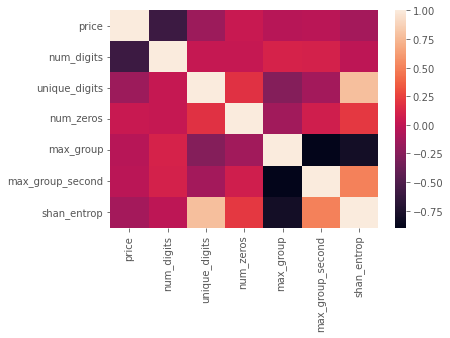

In [7]:
sns.heatmap(df.select_dtypes(include = np.number).corr())
# Doesn't seem like there is much of a correlation 
# However some strong anticorrelations 

In [8]:
# There is a chance that people like specific numbers 
# So num_x columns for all numbers might be good feature extraction
# There is a bias variance tradeoff, but given we have ~3k samples, it should be passable

nums_list = ['ones','twos','threes',
             'fours','fives','sixes',
             'sevens','eights','nines']
num_dict = {word:str(num) for word,num\
            in zip(nums_list,range(1,10))}

for word,num in num_dict.items():
    df[f'num_{word}'] = df['number'].apply(lambda x: x.count(num))
    
df.head()

,number,code,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,num_ones,num_twos,num_threes,num_fours,num_fives,num_sixes,num_sevens,num_eights,num_nines
0,1313,U,109000,4,2,0,2,2,1.000000,2,0,2,0,0,0,0,0,0
1,3222,H,72000,4,2,0,3,1,0.811278,0,3,1,0,0,0,0,0,0
2,30033,P,24000,5,2,2,3,2,0.970951,0,0,3,0,0,0,0,0,0
3,7765,L,17500,4,3,0,2,1,1.500000,0,0,0,0,1,1,2,0,0
4,8876,U,17500,4,3,0,2,1,1.500000,0,0,0,0,0,1,1,2,0


### Scaling numerical columns

In [9]:
# Keep numeric columns to apply transforms to later
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('price')
num_cols

['num_digits',
 'unique_digits',
 'num_zeros',
 'max_group',
 'max_group_second',
 'shan_entrop',
 'num_ones',
 'num_twos',
 'num_threes',
 'num_fours',
 'num_fives',
 'num_sixes',
 'num_sevens',
 'num_eights',
 'num_nines']

In [10]:
df[num_cols] = MinMaxScaler().fit(df[num_cols]).transform(df[num_cols])

df

,number,code,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,num_ones,num_twos,num_threes,num_fours,num_fives,num_sixes,num_sevens,num_eights,num_nines
0,1313,U,109000,0.5,0.000000,0.0,0.333333,1.0,0.173795,0.666667,0.00,0.666667,0.0,0.000000,0.000000,0.000000,0.00,0.000000
1,3222,H,72000,0.5,0.000000,0.0,0.666667,0.0,0.055844,0.000000,0.75,0.333333,0.0,0.000000,0.000000,0.000000,0.00,0.000000
2,30033,P,24000,1.0,0.000000,1.0,0.666667,1.0,0.155639,0.000000,0.00,1.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000
3,7765,L,17500,0.5,0.333333,0.0,0.333333,0.0,0.486295,0.000000,0.00,0.000000,0.0,0.333333,0.333333,0.666667,0.00,0.000000
4,8876,U,17500,0.5,0.333333,0.0,0.333333,0.0,0.486295,0.000000,0.00,0.000000,0.0,0.000000,0.333333,0.333333,0.50,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2963,26277,U,2400,1.0,0.333333,0.0,0.333333,1.0,0.500000,0.000000,0.50,0.000000,0.0,0.000000,0.333333,0.666667,0.00,0.000000
2964,28299,U,2400,1.0,0.333333,0.0,0.333333,1.0,0.500000,0.000000,0.50,0.000000,0.0,0.000000,0.000000,0.000000,0.25,0.666667
2965,63383,U,2400,1.0,0.333333,0.0,0.666667,0.0,0.405639,0.000000,0.00,1.000000,0.0,0.000000,0.333333,0.000000,0.25,0.000000
2966,93966,U,2400,1.0,0.333333,0.0,0.333333,1.0,0.500000,0.000000,0.00,0.333333,0.0,0.000000,0.666667,0.000000,0.00,0.666667


### One hot encode categorical column

In [11]:
# one-hot encoder
OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

# one hot encoded dataframe
df_oh = pd.DataFrame(OH_encoder.fit_transform(np.array(df['code']).reshape(-1,1)))

# Get rid of code column to replace with encoded columns
df = df.drop(['code'],axis = 1)

# join the column to the main dataframe
df = df.join(df_oh)

df.head()

,number,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,num_ones,num_twos,...,13,14,15,16,17,18,19,20,21,22
0,1313,109000,0.5,0.000000,0.0,0.333333,1.0,0.173795,0.666667,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3222,72000,0.5,0.000000,0.0,0.666667,0.0,0.055844,0.000000,0.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30033,24000,1.0,0.000000,1.0,0.666667,1.0,0.155639,0.000000,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7765,17500,0.5,0.333333,0.0,0.333333,0.0,0.486295,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8876,17500,0.5,0.333333,0.0,0.333333,0.0,0.486295,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   number            2968 non-null   object 
 1   price             2968 non-null   int64  
 2   num_digits        2968 non-null   float64
 3   unique_digits     2968 non-null   float64
 4   num_zeros         2968 non-null   float64
 5   max_group         2968 non-null   float64
 6   max_group_second  2968 non-null   float64
 7   shan_entrop       2968 non-null   float64
 8   num_ones          2968 non-null   float64
 9   num_twos          2968 non-null   float64
 10  num_threes        2968 non-null   float64
 11  num_fours         2968 non-null   float64
 12  num_fives         2968 non-null   float64
 13  num_sixes         2968 non-null   float64
 14  num_sevens        2968 non-null   float64
 15  num_eights        2968 non-null   float64
 16  num_nines         2968 non-null   float64


In [13]:
df[num_cols]

,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,num_ones,num_twos,num_threes,num_fours,num_fives,num_sixes,num_sevens,num_eights,num_nines
0,0.5,0.000000,0.0,0.333333,1.0,0.173795,0.666667,0.00,0.666667,0.0,0.000000,0.000000,0.000000,0.00,0.000000
1,0.5,0.000000,0.0,0.666667,0.0,0.055844,0.000000,0.75,0.333333,0.0,0.000000,0.000000,0.000000,0.00,0.000000
2,1.0,0.000000,1.0,0.666667,1.0,0.155639,0.000000,0.00,1.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000
3,0.5,0.333333,0.0,0.333333,0.0,0.486295,0.000000,0.00,0.000000,0.0,0.333333,0.333333,0.666667,0.00,0.000000
4,0.5,0.333333,0.0,0.333333,0.0,0.486295,0.000000,0.00,0.000000,0.0,0.000000,0.333333,0.333333,0.50,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2963,1.0,0.333333,0.0,0.333333,1.0,0.500000,0.000000,0.50,0.000000,0.0,0.000000,0.333333,0.666667,0.00,0.000000
2964,1.0,0.333333,0.0,0.333333,1.0,0.500000,0.000000,0.50,0.000000,0.0,0.000000,0.000000,0.000000,0.25,0.666667
2965,1.0,0.333333,0.0,0.666667,0.0,0.405639,0.000000,0.00,1.000000,0.0,0.000000,0.333333,0.000000,0.25,0.000000
2966,1.0,0.333333,0.0,0.333333,1.0,0.500000,0.000000,0.00,0.333333,0.0,0.000000,0.666667,0.000000,0.00,0.666667
